<a href="https://colab.research.google.com/github/KonstantinBurkin/Math_for_DS_exam/blob/main/math_for_DS_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#"Math for Data Science" exam

The introduction course to math for data science, MSU Fall 2021 - Spring 2022. Link to course [here](https://github.com/MSUcourses/Data-Analysis-with-Python/tree/main/Math) or [here](https://github.com/amkatrutsa/msu_intro_ds2021).

##Import packages

In [ ]:
import numpy as np
import scipy.optimize as scopt
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax
from jax.config import config                       
config.update("jax_enable_x64", True)               # provides float64 accuracy

##Conditions of the problem

Solve following function minimization problems

Function: $f(x)\ =\ ∣∣Ax−b∣∣^3_{2}$



The initial approximation is the zero vector.

In [ ]:
np.random.seed(0)

m = 100
n = 10
A = np.random.randn(m, n)     # generate matrix 
b = np.random.randn(m)        # generate vector

x0 = jax.numpy.zeros(n)       # initial approximation
eps = 1e-4                    # accuracy
alpha = 1e-4                  # constant step 
num_iter = 2000               # max number of iterations

f = lambda x: (jax.numpy.linalg.norm(A@x - b))**3
gradf = jax.grad(f)

##1. Calculate number of iterations for gradient descent

How many iterations does the gradient descent method with a constant step=1e-4 take to achieve an accuracy in gradient norm less than 1e-4?

Answer:  88  iterations



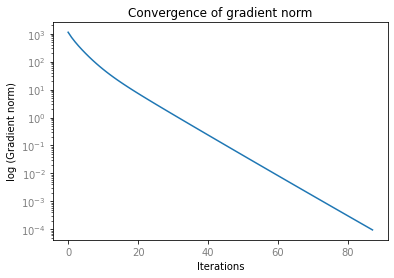

In [ ]:
def grad_descent(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    conv = [x]
    norm_gd = []
    for i in range(num_iter):
        h = -grad(x)
        norm_gd.append(np.linalg.norm(h))
        if jnp.linalg.norm(h) < eps:
            break
        x = x + alpha * h
        conv.append(x)
    return x, conv, i, norm_gd

x_gd, conv_gd, i_gd, norm_gd = grad_descent(f, gradf, x0, num_iter, eps, alpha)
print("Answer: ",i_gd+1, " iterations\n")             # +1 b/c count from 0

# plot the convergence of gradient norm
plt.semilogy([x for x in norm_gd])
plt.title("Convergence of gradient norm")
plt.xlabel('Iterations')
plt.ylabel('log (Gradient norm)')
plt.yticks(color='grey'); plt.xticks(color='grey')
plt.show()      

##2. Calculate number of iterations for heavy ball method

How many iterations does the heavy ball method with a constant step=1e-4 and coefficient β=0.5 take to achieve an accuracy in the gradient norm less than 1e-4?

Answer:  47  iterations



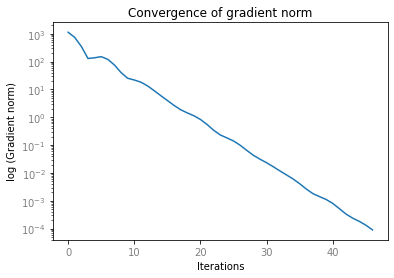

In [ ]:
def heavy_ball(f, grad, x0, num_iter, eps, alpha, beta):
    x = x0.copy()
    conv = [x.copy()]
    prev_x = None
    norm_hb = []
    for i in range(num_iter):
        h = -grad(x)
        norm_hb.append(np.linalg.norm(h))
        if jax.numpy.linalg.norm(h) < eps:
          break
        if prev_x is None:
            prev_x = x
            x = x + alpha * h
        else:
            x, prev_x = x + alpha * h + beta * (x - prev_x), x
        conv.append(x.copy())
    return x, conv, i, norm_hb

x, conv_hb, i, norm_hb = heavy_ball(f, gradf, x0, num_iter, eps, alpha, beta=0.5)
print("Answer: ",i+1, " iterations\n")              # +1 b/c count from 0

# plot the convergence of gradient norm
plt.semilogy([x for x in norm_hb])
plt.title("Convergence of gradient norm")
plt.xlabel('Iterations')
plt.ylabel('log (Gradient norm)')
plt.yticks(color='grey'); plt.xticks(color='grey')
plt.show()    

##3. Calculate number of iterations for accelerated gradient descent method

How many iterations does the accelerated gradient method with a constant step=3e-4 take to achieve an accuracy in gradient norm less than 1e-4? Note at what point you need to calculate the gradient to evaluate the accuracy.

Answer:  33  iterations



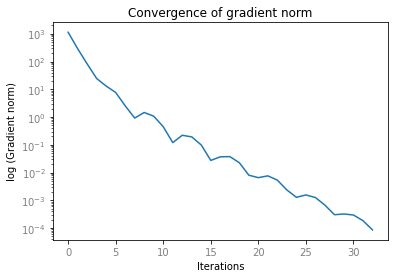

In [ ]:
alpha = 3e-4              # new step

def accelerated_gd(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    y = x0.copy()
    conv = [x]
    norm_acc_gd = []
    prev_x = None
    for i in range(num_iter):
        h = -grad(y)
        norm_acc_gd.append(np.linalg.norm(h))
        if np.linalg.norm(h) < eps:
            break
        if prev_x is None:
            prev_x = x.copy()
            x = y + alpha * h
        else:
            x, prev_x = y + alpha * h, x
        
        y = x + (i+1.) / (i+4.) * (x - prev_x)
            
        conv.append(x)
    return x, conv, i, norm_acc_gd


x_acc_gd, conv_acc_gd, i_acc_gd, norm_acc_gd = accelerated_gd(f, gradf, x0, num_iter, eps, alpha)
print("Answer: ",i_acc_gd+1, " iterations\n")             # +1 b/c count from 0

# plot the convergence of gradient norm
plt.semilogy([x for x in norm_acc_gd])
plt.title("Convergence of gradient norm")
plt.xlabel('Iterations')
plt.ylabel('log (Gradient norm)')
plt.yticks(color='grey'); plt.xticks(color='grey')
plt.show()     

##4. Calculate the iteration when Newton method begins to stagnate

After how many iterations does Newton's method with a constant step=1e-1 begins to stagnate, that is, the gradient norm stops changing? In your answer, indicate the number of iteration k such that the value of the gradient norm at the next iteration k+1 remains the same.

What rate of convergence of Newton's method is observed in the norm of the gradient?

Answer:  144 iteration



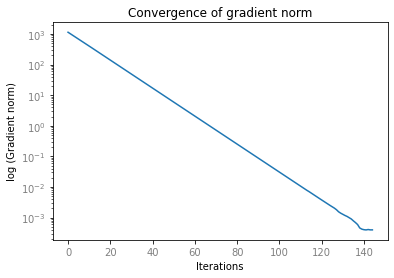

In [ ]:
from jax.config import config                       
config.update("jax_enable_x64", False)               # set back to float32

np.random.seed(0)

m = 100
n = 10
A = np.random.randn(m, n)     # generate matrix 
b = np.random.randn(m)        # generate vector

x0 = jax.numpy.zeros(n)       # initial approximation
eps = 1e-4                    # accuracy
alpha = 1e-1                  # constant step 
num_iter = 500               # max number of iterations

f = lambda x: (jax.numpy.linalg.norm(A@x - b))**3
gradf = jax.grad(f)


# https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization#Higher_dimensions
def newton_minimize(f, gradf, hessf, x0, alpha, num_iter):
    x = x0.copy()
    conv = [x]
    norm = []
    prev_norm = None
    for i in range(num_iter):
        H = hessf(x)
        g = gradf(x)
        x = x - alpha * jax.numpy.linalg.solve(H, g)

        norm.append(np.linalg.norm(g))

        if norm[-1] == prev_norm:
            # -1 b/c started to stagnate on previous step
            # +1 b/c count from 0
            break

        prev_norm = norm[-1]
        conv.append(x)
    return x, conv, norm, i

hess = jax.hessian(f)
x, conv, norm, i = newton_minimize(f, gradf, hess, x0, alpha, num_iter)
print("Answer: ",i, "iteration\n")

# plot the convergence of gradient norm
plt.semilogy([x for x in norm])
plt.title("Convergence of gradient norm")
plt.xlabel('Iterations')
plt.ylabel('log (Gradient norm)')
plt.yticks(color='grey'); plt.xticks(color='grey')
plt.show()      

The rate of convergence  in the norm of the gradient is linear.